In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.metrics import r2_score


In [162]:
dataset_name = 'chewie_10_05'
model_str='kl1_gauss_bd'
# model_str='fixKLL2_v5_const_lr'

bin_size_ms = 10

N_FOLDS = 5

In [165]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 8,4
bw = 0.1
encod_seq_len = 100
encod_data_dim = 244
seed = 2
# model_names = ['240520_lfads_minloss_KL1', '240520_band_minloss_KL1']
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
# model_names[0] += '_bs256'
model_dests = [[f"{models_dest}_cv{cv}/{model_name}" for cv in range(N_FOLDS)] for model_name in model_names]

model_dests


[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv0/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv1/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv2/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv3/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv0/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv1/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv2/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv3/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkud

In [166]:
# model_dests[-1][0] = '/disk/scratch2/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/chewie_10_07_cv0/band_both_8f_fixKLL2'
# model_dests[0] = [f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}_cv{cv}/lfads_both_8f_4c_kl1_gauss_bd05" for cv in range(N_FOLDS)]
model_dests

[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv0/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv1/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv2/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv3/lfads_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv0/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv1/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv2/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv3/band_both_8f_4c_kl1_gauss_bd',
  '/disk/scratch2/nkud

In [167]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten

models = []
for fold in range(N_FOLDS):

    overrides={
            "datamodule": dataset_name.split('_cv')[0],
            "datamodule.fold": fold,
            "model": model_str, # older models were run with list of beh decoders
            "model.encod_seq_len": encod_seq_len,
            "model.recon_seq_len": encod_seq_len,
            "model.kl_co_scale": float(encod_seq_len),
            "model.fac_dim": fac_dim,
            "model.co_dim": co_dim,
            "model.encod_data_dim": encod_data_dim,
            # "model.behavior_weight": bw,
        }
    # config_path="../../configs/pbt.yaml"
    config_path="../../configs/single.yaml"
    print(config_path)

    # Compose the train config with properly formatted overrides
    config_path = Path(config_path)
    overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
    with hydra.initialize(
        config_path=config_path.parent,
        job_name="get_weights",
        version_base="1.1",
    ):
        config = hydra.compose(config_name=config_path.name, overrides=overrides)

    # Instantiate `LightningDataModule` and `LightningModule`
    datamodule = instantiate(config.datamodule, _convert_="all")
    model = instantiate(config.model)

    from glob import glob
    checkpoint_folders = glob(model_dests[-1][fold]+'/best_model/checkpoint*')

    print(model_dests[-1][fold])

    # ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    ckpt_path = f'{model_dests[-1][fold]}/lightning_checkpoints/last.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    models.append(model)

../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv0/band_both_8f_4c_kl1_gauss_bd
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv1/band_both_8f_4c_kl1_gauss_bd
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv2/band_both_8f_4c_kl1_gauss_bd
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv3/band_both_8f_4c_kl1_gauss_bd
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/band_both_8f_4c_kl1_gauss_bd


FOLD 0


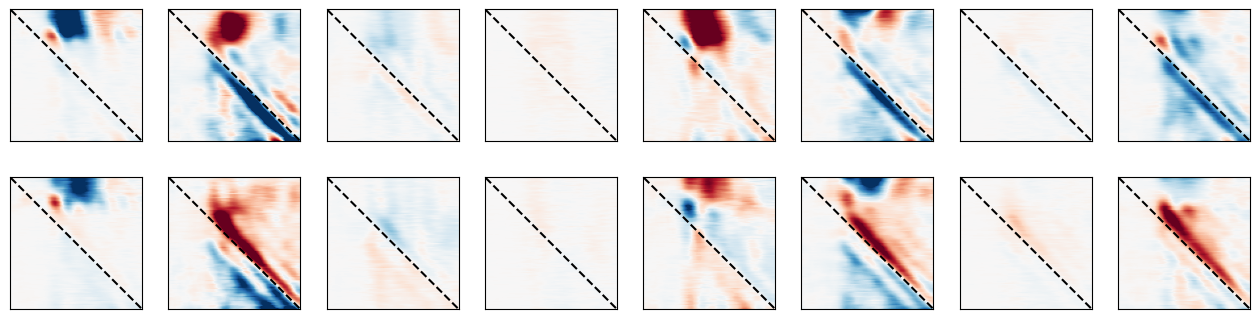

FOLD 1


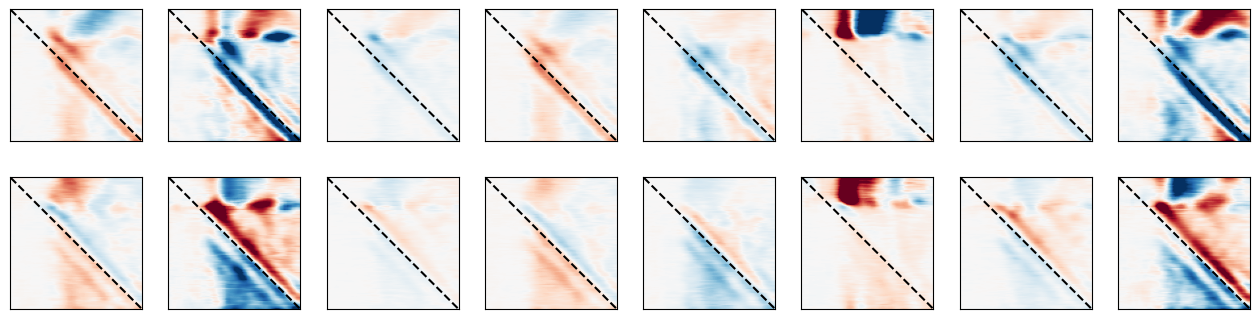

FOLD 2


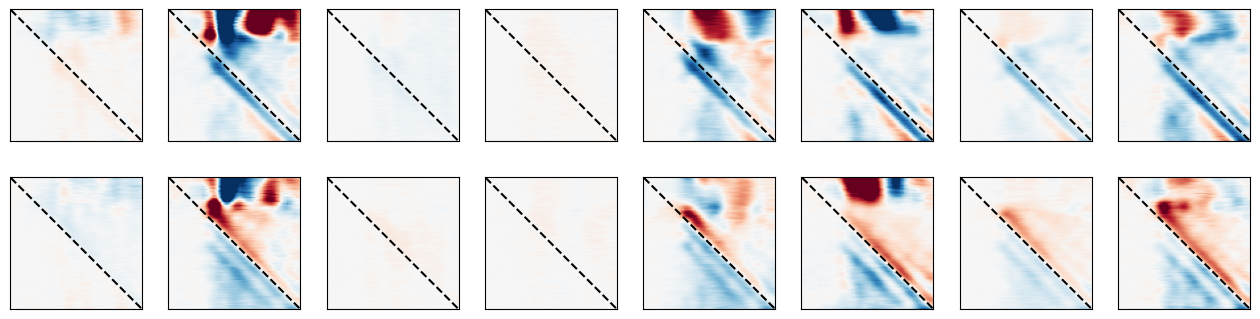

FOLD 3


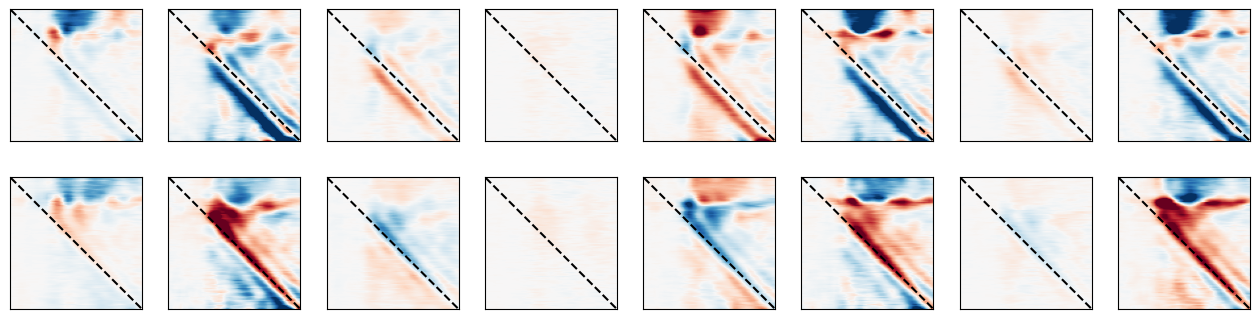

FOLD 4


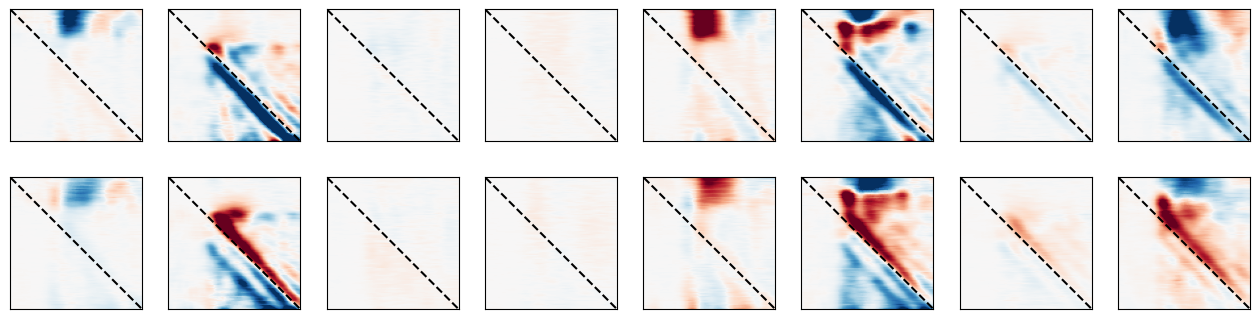

In [168]:
beh_Ws = []
for fold, model in enumerate(models):
    seq_len = config.model.recon_seq_len
    # in_features = config.model.behavior_readout.modules[0].in_features
    # out_features = config.model.behavior_readout.modules[0].out_features
    # beh_W = model.behavior_readout[0].layers[1].weight.T

    in_features = config.model.behavior_readout.in_features
    out_features = config.model.behavior_readout.out_features
    beh_W = model.behavior_readout.layers[2].weight.T

    assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

    beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

    r = torch.std(beh_W)*4
    print('FOLD', fold)
    fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features))
    for j in range(in_features):
        for i in range(out_features):
            ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')

    plt.show()

    beh_Ws.append(beh_W)

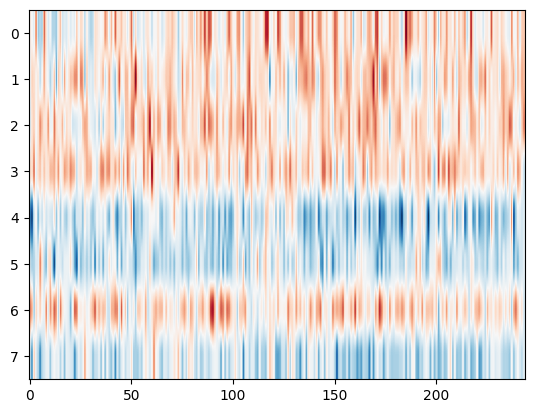

In [169]:
n_W = model.readout[0].weight.T
plt.imshow(n_W.detach().numpy(),interpolation=None, cmap='RdBu',aspect='auto')

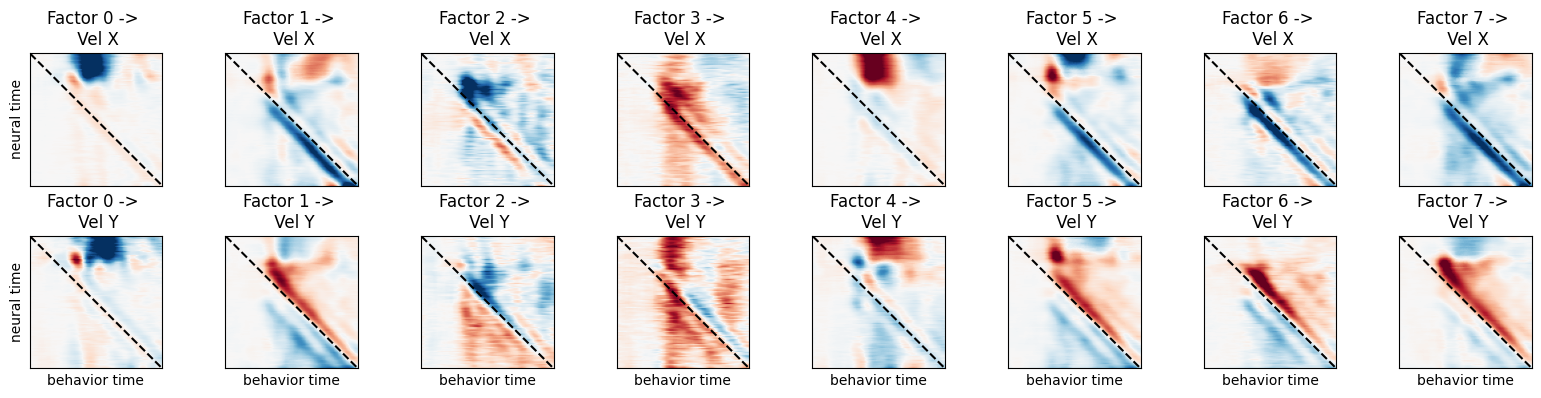

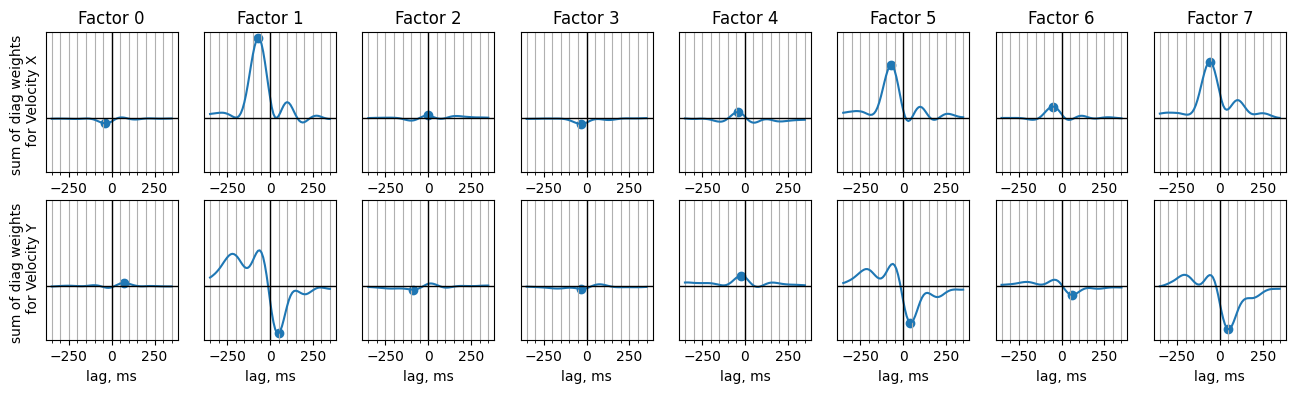

In [170]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

beh_W = np.array([b.detach().numpy() for b in beh_Ws]).mean(0)
fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features))
for j in range(in_features):
    for i in range(out_features):
        r = np.std(beh_W[:,j,:,i])*4
        ax[i,j].imshow(beh_W[:,j,:,i], cmap='RdBu', vmin=-r, vmax=r)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')
    ax[0,j].set_title(f'Factor {j} -> \n Vel X')
    ax[1,j].set_title(f'Factor {j} -> \n Vel Y')

for i in range(out_features):
    ax[i,0].set_ylabel(f'neural time')
for j in range(in_features):
    ax[-1,j].set_xlabel(f'behavior time')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features),sharey=True)
for j in range(in_features):
    for i in range(out_features):
        w = beh_W[:,j,:,i][50:,50:]
        # ax[i,j].imshow(w)
        lags = np.arange(-35, 36)
        amp = np.zeros_like(lags, dtype=float)
        for k,lag in enumerate(lags):
            amp[k] = np.sum(np.diag(w, k=lag))
        ax[i,j].plot(10*lags,amp)
        id_max = np.argmax(np.abs(amp))
        ax[i,j].scatter(10*lags[id_max], amp[id_max])
        ax[i,j].axhline(0, color='k', linewidth=1)
        ax[i,j].axvline(0, color='k', linewidth=1)
        # ax[i,j].axhline(w.mean(), color='r', linewidth=1)
        ax[i,j].set_yticks([])
        ax[i,j].xaxis.set_minor_locator(MultipleLocator(50))
        ax[i,j].grid(True,which='both')
    ax[0,j].set_title(f'Factor {j}')

for i,n in enumerate(['Velocity X','Velocity Y']):
    ax[i,0].set_ylabel(f'sum of diag weights \n for {n}')
for j in range(in_features):
    ax[-1,j].set_xlabel(f'lag, ms')

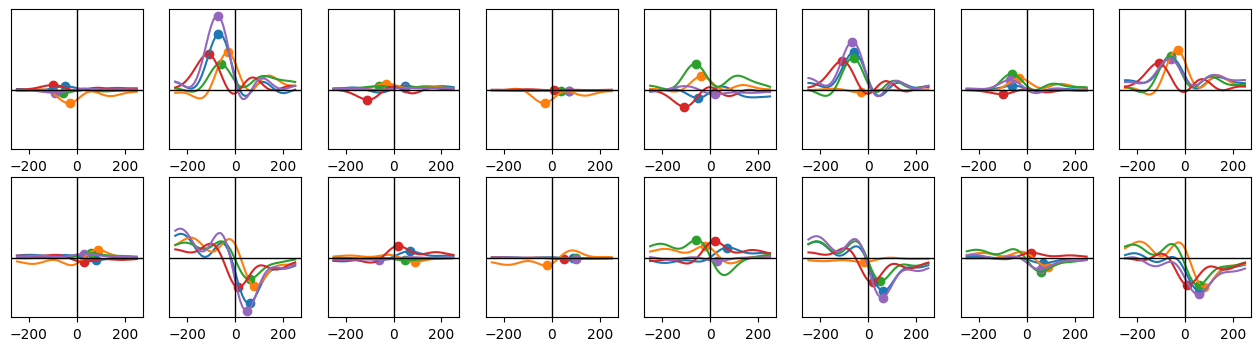

In [171]:
fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features),sharey=True)
for j in range(in_features):
    for i in range(out_features):
        for fold in range(N_FOLDS):
            w = beh_Ws[fold][:,j,:,i].detach().numpy()[25:,25:]
            lags = np.arange(-25, 26)
            amp = np.zeros_like(lags, dtype=float)
            for k,lag in enumerate(lags):
                amp[k] = np.sum(np.diag(w, k=lag))
            ax[i,j].plot(10*lags,amp)
            id_max = np.argmax(np.abs(amp))
            ax[i,j].scatter(10*lags[id_max], amp[id_max])
        ax[i,j].axhline(0, color='k', linewidth=1)
        ax[i,j].axvline(0, color='k', linewidth=1)
        ax[i,j].set_yticks([])

In [172]:
trial_num = 0
for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        valid_inds = f["valid_inds"][:]
        valid_epoch = f["valid_epoch"][:]
        true_valid_beh = f['valid_vel'][:]
        valid_data = f['valid_recon_data'][:]

    assert np.all(np.diff(valid_epoch)>=0), 'Epochs are not sorted'
    assert [np.all(np.diff(valid_inds[valid_epoch==e]) > 0) for e in [0,1,2]], 'Indices are not sorted'

    trial_num+=len(valid_inds)

print(trial_num, true_valid_beh.shape, valid_data.shape)


613 (122, 100, 2) (122, 100, 244)


In [173]:
# # swap to radial coordinates
# for fold in range(N_FOLDS):
#     datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
#     data_paths = sorted(glob(datafile_pattern))
#     assert len(data_paths) == 1, 'Assumed a single dataset, got more'
#     dataset_filename = data_paths[0] 
#     sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

#     print(dataset_filename)

#     with h5py.File(dataset_filename, 'r') as f:

#         polar_vel = {}
#         for d_key in ['train', 'valid']:
#             vel = f[f'{d_key}_vel'][:]
#             pos = f[f'{d_key}_pos'][:]

#             dir = pos / np.linalg.norm(pos, axis=-1, keepdims=True)
#             # project vel on dir
#             radial_vel = np.sum(vel*dir, axis=-1, keepdims=True)*dir
#             tan_vel = vel - radial_vel
#             polar_vel[d_key] = np.concatenate([np.sum(vel*dir, axis=-1, keepdims=True), 
#                                                np.cross(dir,vel, axis=-1)[...,np.newaxis]]
#                                                , axis=-1)
#             print(radial_vel.shape,tan_vel.shape)
#             assert np.allclose(np.sum(vel*dir, axis=-1)**2 + np.cross(dir,vel, axis=-1)**2,
#                             np.linalg.norm(vel,axis=-1)**2)
            
#             print(polar_vel[d_key].shape)

#         # write to file, substituting train_behavior with vel in polar coordinates (radial, tan)
#         new_filename = dataset_filename.replace('go_cv', 'go_polar_cv')
#         print(new_filename)
#         with h5py.File(new_filename, 'w') as f_new:
#             for key in f.keys():
#                 if key == 'train_behavior':
#                     f_new.create_dataset('train_behavior', data=polar_vel['train'])
#                 elif key == 'valid_behavior':
#                     f_new.create_dataset('valid_behavior', data=polar_vel['valid'])
#                 else:
#                     f_new.create_dataset(key, data=f[key][:])
        

In [174]:
# # # swap X-Y coordinates
# for fold in range(N_FOLDS):
#     datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
#     data_paths = sorted(glob(datafile_pattern))
#     assert len(data_paths) == 1, 'Assumed a single dataset, got more'
#     dataset_filename = data_paths[0] 
#     sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

#     print(dataset_filename)

#     with h5py.File(dataset_filename, 'r') as f:

#         # write to file, substituting train_behavior with vel in polar coordinates (radial, tan)
#         new_filename = dataset_filename.replace('go_cv', 'go_flipXY_cv')
#         print(new_filename)
#         with h5py.File(new_filename, 'w') as f_new:
#             for key in f.keys():
#                 if key == 'train_behavior':
#                     v = np.concatenate([f['train_behavior'][:,:,[1]], f['train_behavior'][:,:,[0]]], axis=-1)
#                     print(v.shape)
#                     f_new.create_dataset('train_behavior', data=v)
#                 elif key == 'valid_behavior':
#                     v = np.concatenate([f['valid_behavior'][:,:,[0]], f['valid_behavior'][:,:,[0]]], axis=-1)
#                     f_new.create_dataset('valid_behavior', data=v)
#                 else:
#                     f_new.create_dataset(key, data=f[key][:])
        

In [175]:
# load the dataset
both_factors = []
both_train_factors = []
both_factors_noci = []
both_train_factors_noci = []
# both_controls = []
# both_rates = []
# both_train_rates = []
# both_noci_rates = []
# both_train_noci_rates = []
# both_ics = []
# both_behaviors = []
# seq2seq_decoded_behs = []
true_train_behs = []
true_valid_behs = []
both_train_epochs = []
both_valid_epochs = []

# create empty arrays for LFADS/BAND behavior predictions
concat_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_noci_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_true_behavior = np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan
concat_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_noci_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_data = np.ones((trial_num,*valid_data.shape[1:]))*np.nan
concat_factors = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_factors_noci = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_epochs = np.ones((trial_num,))*np.nan
concat_ids = np.ones((trial_num,))*np.nan
concat_target_direction = np.ones((trial_num,))*np.nan


for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        train_data = f['train_recon_data'][:]
        valid_data = f['valid_recon_data'][:]
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        train_epoch = f["train_epoch"][:]
        valid_epoch = f["valid_epoch"][:]
        true_train_beh = f['train_vel'][:]
        true_valid_beh = f['valid_vel'][:]
        true_target_direction = f['valid_target_direction'][:]

    print(valid_inds[valid_epoch==0])

    true_pos = np.cumsum(true_valid_beh,axis=1) 

    def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
        n_samples = len(train_data) + len(valid_data)
        merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
        merged_data[train_inds] = train_data
        merged_data[valid_inds] = valid_data
        return merged_data

    for mi, model_name in enumerate(model_names):
        print(model_name)
        sess_name = f'cv{fold}'
        # data_path = os.path.join(model_dests[mi][fold],'best_model','',f'lfads_output_{sess_name}.h5')
        data_path = os.path.join(model_dests[mi][fold],f'lfads_output_{sess_name}.h5')
        bin_width_s = .01 # chewie
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            print(f.keys())
            # Merge train and valid data for factors and rates
            train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
            factors = f["valid_factors"][:]
            rates = f["valid_output_params"][:] / bin_width_s
            behavior = f["valid_output_behavior_params"][:]
            controls = f['valid_gen_inputs'][:]
            ic = f['valid_gen_init'][:]
            control_mean = f['valid_co_means'][:]
            control_stds = f['valid_co_stds'][:]

            train_factors = f["train_factors"][:]
            train_controls = f['train_gen_inputs'][:]
            train_ic = f['train_gen_init'][:]
            train_rates = f["train_output_params"][:] / bin_width_s

        # load ablated model components
        data_path = os.path.join(model_dests[mi][fold],f'lfads_ablated_output_{sess_name}.h5')
        with h5py.File(data_path) as f:
            noci_factors = f["valid_factors"][:]
            noci_train_factors = f["train_factors"][:]
            noci_behavior = f["valid_output_behavior_params"][:]

            noci_rates = f["valid_output_params"][:] / bin_width_s
            noci_train_rates = f["train_output_params"][:] / bin_width_s
            # noci_controls = f['valid_gen_inputs'][:]

        # Ridge seq2seq
        X_train = train_factors.reshape(train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = factors.reshape(factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # Ridge seq2seq from noci factors
        X_train = noci_train_factors.reshape(noci_train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = noci_factors.reshape(noci_factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_noci_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # PCA on initial conditions
        pca = PCA(n_components=2)
        pca.fit(train_ic)
        ic_pca = pca.transform(ic)
        print(train_ic.shape,ic_pca.shape)
                
        both_factors.append(factors)
        both_train_factors.append(train_factors)
        both_factors_noci.append(noci_factors)
        both_train_factors_noci.append(noci_train_factors)
        # both_controls.append(controls)
        # both_rates.append(rates)
        # both_train_rates.append(train_rates)
        # both_noci_rates.append(noci_rates)
        # both_train_noci_rates.append(noci_train_rates)
        # both_ics.append(ic_pca)
        # both_behaviors.append(behavior)
        true_train_behs.append(true_train_beh)
        true_valid_behs.append(true_valid_beh)
        both_train_epochs.append(train_epoch)
        both_valid_epochs.append(valid_epoch)
        # seq2seq_decoded_behs.append(Y_pred_seq2seq)

        concat_behaviors[mi][fold::N_FOLDS] = Y_pred_seq2seq
        concat_noci_behaviors[mi][fold::N_FOLDS] = Y_pred_noci_seq2seq
        concat_rates[mi][fold::N_FOLDS] = rates
        concat_noci_rates[mi][fold::N_FOLDS] = noci_rates
        concat_factors[mi][fold::N_FOLDS] = factors
        concat_factors_noci[mi][fold::N_FOLDS] = noci_factors
        if mi == 0:
            concat_data[fold::N_FOLDS] = valid_data
            concat_true_behavior[fold::N_FOLDS] = true_valid_beh
            concat_epochs[fold::N_FOLDS] = valid_epoch
            concat_ids[fold::N_FOLDS] = valid_inds
            concat_target_direction[fold::N_FOLDS] = true_target_direction
        else:
            assert np.all(concat_epochs[fold::N_FOLDS] == valid_epoch), 'Epochs do not match'
            assert np.all(concat_data[fold::N_FOLDS] == valid_data), 'Data does not match'
            assert np.all(concat_ids[fold::N_FOLDS] == valid_inds), 'Indices do not match'
            assert np.all(concat_target_direction[fold::N_FOLDS] == true_target_direction), 'Target directions do not match'
            assert np.all(concat_true_behavior[fold::N_FOLDS] == true_valid_beh), 'True behavior does not match'

[  2   7  15  23  28  33  39  44  49  55  60  66  72  77  87  93  98 103
 109 115 123 129 136 142 147 153 158 163 170 178 186 198 204 209 215 220
 225 232 237 245 251]
lfads_both_8f_4c_kl1_gauss_bd
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(490, 200) (123, 2)
band_both_8f_4c_kl1_gauss_bd
<KeysViewHDF5 ['train_b

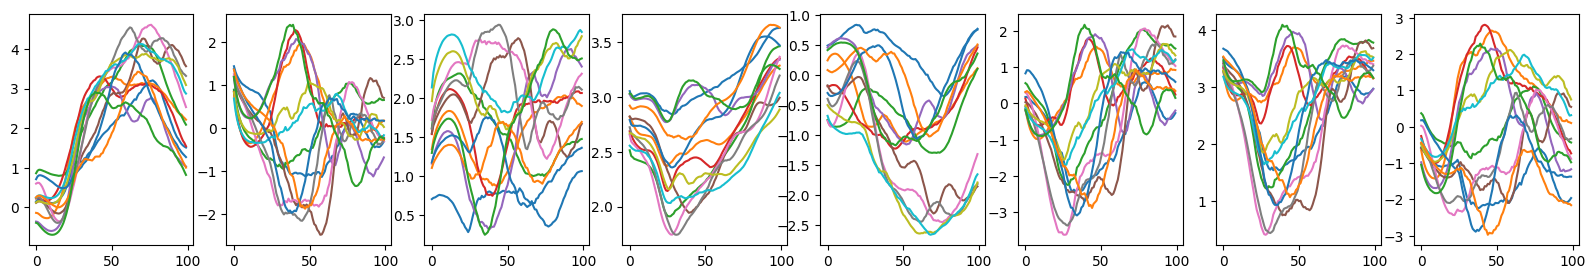

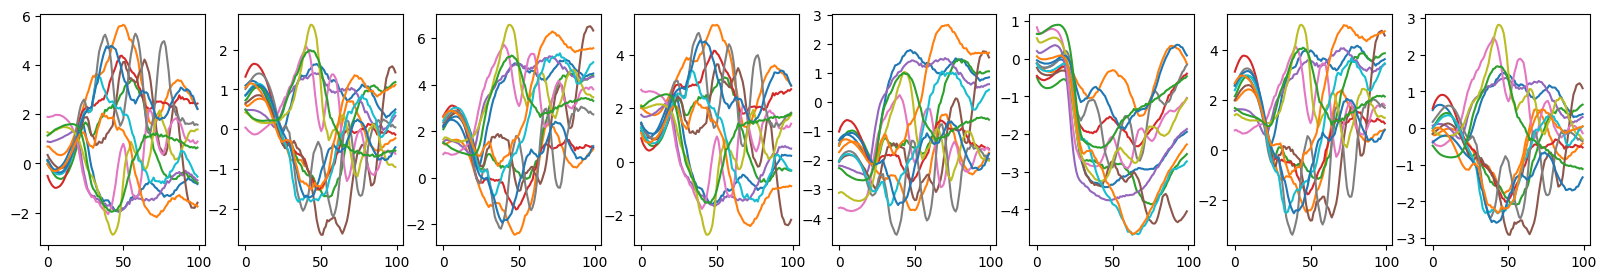

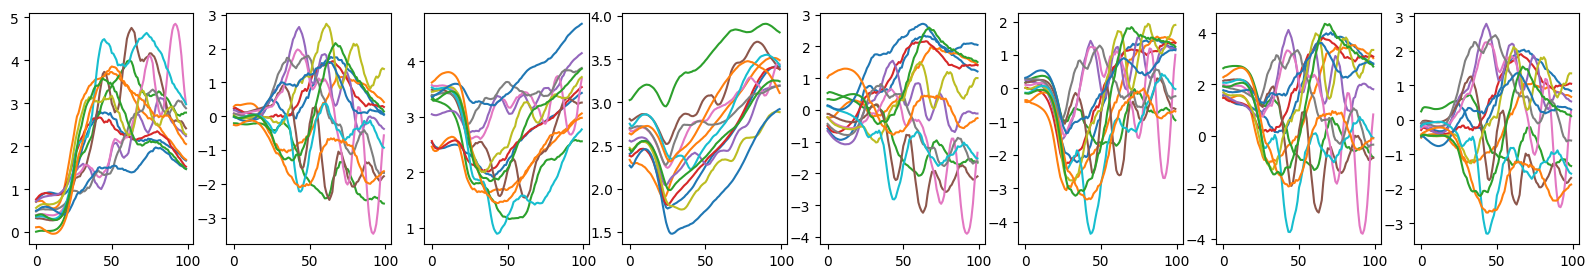

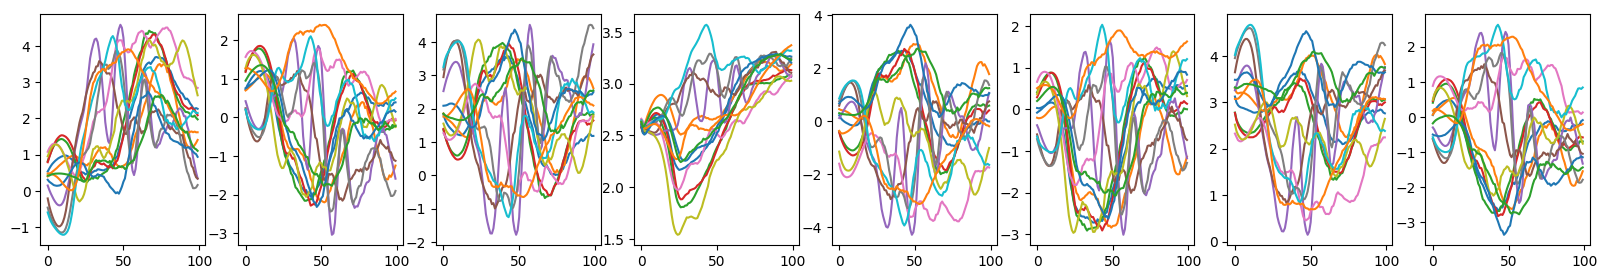

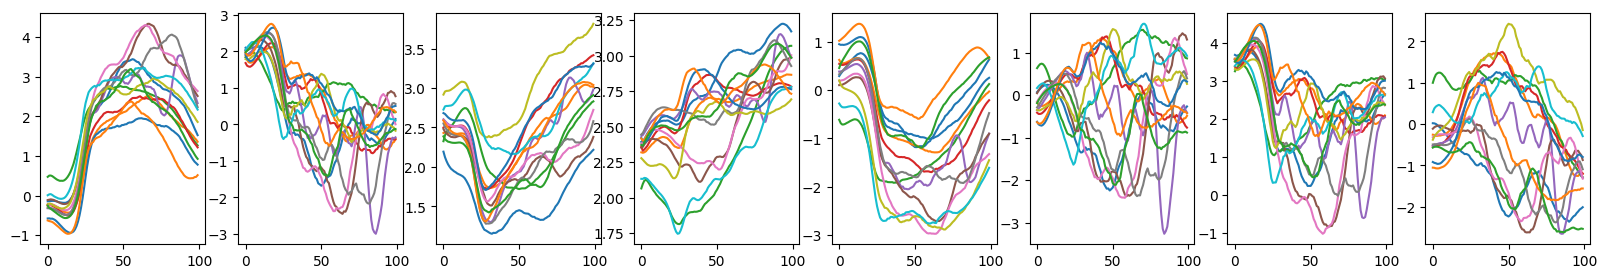

In [176]:
# plot factors
for fold in range(N_FOLDS):
    fig, ax = plt.subplots(1,fac_dim,figsize=(20,3))
    for n_f in range(fac_dim):
        ax[n_f].plot(both_factors[2*fold+1][::10,:,n_f].T)
    

In [177]:
np.where(concat_epochs==1)

(array([202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
        215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
        228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
        241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
        267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
        280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
        293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
        306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
        319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
        332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
        345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
        358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
        371, 372, 373, 374, 375, 376, 377, 378, 379

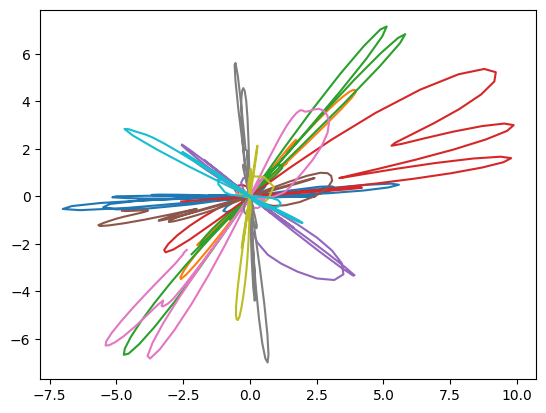

In [178]:
vel = concat_true_behavior.copy()
pos = np.cumsum(vel, axis=1) * bin_width_s
dir = pos / np.linalg.norm(pos, axis=-1, keepdims=True)
radial_vel = np.cross(dir,vel)
radial_vel_vec = radial_vel.reshape(*radial_vel.shape,1) * dir
angular_vel = np.cross(pos,vel) / np.sum(pos**2,axis=-1)

for t in np.where(concat_epochs==1)[0][:10]:
    plt.plot(*radial_vel_vec[t].T)


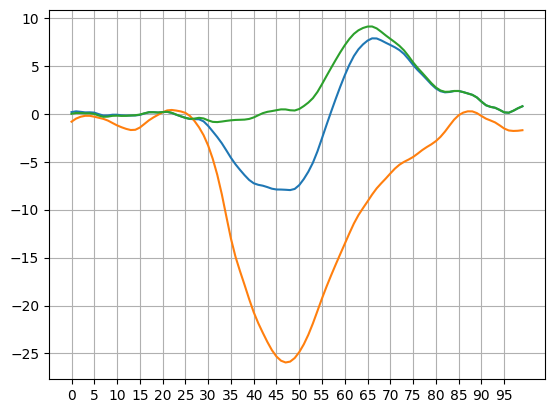

In [179]:
t = 172
# plt.plot(angular_vel[t])
plt.plot(vel[t])
plt.plot(radial_vel[t])
# add grid, make it denser
plt.xticks(np.arange(0,100,5))
plt.grid()

In [180]:
def lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25,alpha=1):
    lags = np.arange(-max_lag,max_lag+1)
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,x_test.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,x_test.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        Y_test = true_valid_beh[:,max_lag:-max_lag]

        # if lag==max_lag:
        #     Y_train = true_train_beh[:,max_lag-lag:].reshape(-1,true_train_beh.shape[-1])
        #     Y_test = true_valid_beh[:,max_lag-lag:]
        # else:
        #     Y_train = true_train_beh[:,max_lag-lag:-max_lag-lag].reshape(-1,true_train_beh.shape[-1])
        #     Y_test = true_valid_beh[:,max_lag-lag:-max_lag-lag]

        # X_train = x_train[:,max_lag:-max_lag].reshape(-1,x_train.shape[-1])
        # X_test = x_test[:,max_lag:-max_lag].reshape(-1,x_test.shape[-1])

        ridge = Ridge(alpha=alpha).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(Y_test.shape)
        r2 = r2_score(Y_pred, Y_test)
        r2s.append(r2)
    return -lags*10, r2s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


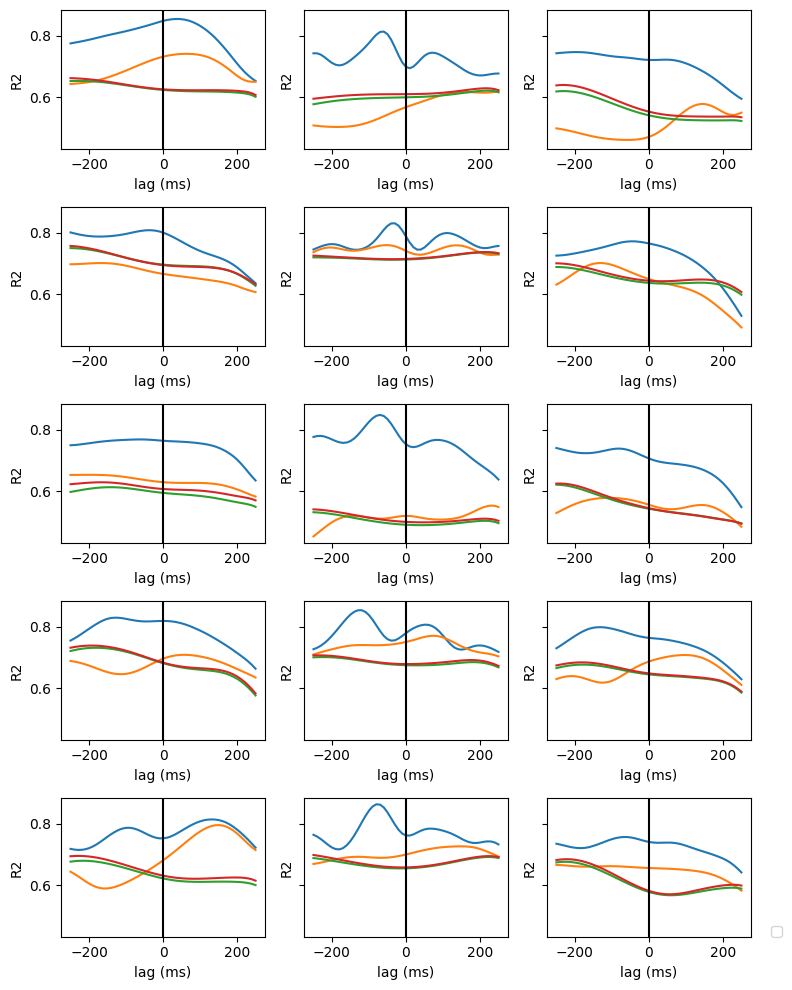

In [192]:
fig, axes = plt.subplots(N_FOLDS,3,figsize=(8,2*5),sharey=True)
alpha=100
# select = [1,5,7]
select = range(8)
for epoch in range(3):
        
    for fold in range(N_FOLDS):
        lfads = 2*fold
        band = 2*fold + 1

        lagr2s = lagged_r2s(both_train_factors[band][both_train_epochs[band] == epoch][:,25:,select],
                            both_factors[band][both_valid_epochs[band] == epoch][:,25:,select], 
                            true_train_behs[band][both_train_epochs[band] == epoch][:,25:],
                            true_valid_behs[band][both_valid_epochs[band] == epoch][:,25:], 
                            alpha=alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C0', label = 'BAND' if fold==0 else None)

        lag2rs = lagged_r2s(both_train_factors_noci[band][both_train_epochs[band] == epoch][:,25:,select],
                            both_factors_noci[band][both_valid_epochs[band] == epoch][:,25:,select],
                            true_train_behs[band][both_train_epochs[band] == epoch][:,25:],
                            true_valid_behs[band][both_valid_epochs[band] == epoch][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lag2rs, c = 'C1', label = 'BAND ablated' if fold==0 else None)

        lagr2s = lagged_r2s(both_train_factors[lfads][both_train_epochs[lfads] == epoch][:,25:],
                            both_factors[lfads][both_valid_epochs[lfads] == epoch][:,25:], 
                            true_train_behs[lfads][both_train_epochs[lfads] == epoch][:,25:],
                            true_valid_behs[lfads][both_valid_epochs[lfads] == epoch][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C2', label = 'LFADS' if fold==0 else None)

        lag2rs = lagged_r2s(both_train_factors_noci[lfads][both_train_epochs[lfads] == epoch][:,25:],
                            both_factors_noci[lfads][both_valid_epochs[lfads] == epoch][:,25:],
                            true_train_behs[lfads][both_train_epochs[lfads] == epoch][:,25:],
                            true_valid_behs[lfads][both_valid_epochs[lfads] == epoch][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lag2rs, c = 'C3', label = 'LFADS ablated' if fold==0 else None)

        axes[fold,epoch].axvline(0,c='k')
        axes[fold,epoch].set_xlabel('lag (ms)')
        axes[fold,epoch].set_ylabel('R2')
plt.legend(loc=(1.1,0))
plt.tight_layout()


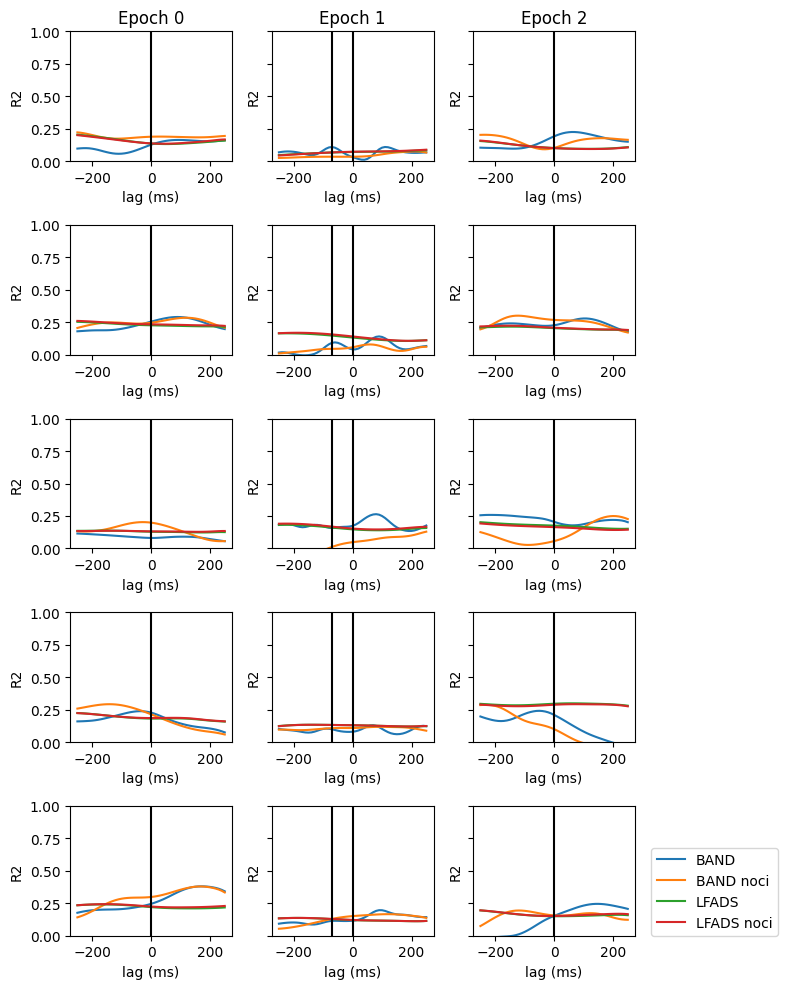

In [190]:


fig, axes = plt.subplots(N_FOLDS,3,figsize=(8,2*N_FOLDS),sharey=True)
alpha=100

vel = radial_vel[...,np.newaxis].copy()

# vel = concat_true_behavior.copy()
# # subtract condition avg
# avg_vel = np.zeros_like(vel)
# for d in np.unique(concat_target_direction):
#     mask = concat_target_direction == d
#     avg_vel[mask] = np.mean(vel[mask], axis=0)
# vel = vel - avg_vel

select = [1,5,7]

for epoch in range(3):
        
    for fold in range(N_FOLDS):
        lfads = 2*fold
        band = 2*fold + 1


        mask_test = np.zeros_like(concat_epochs, dtype=bool)
        mask_test[fold::N_FOLDS] = True

        lagr2s = lagged_r2s(both_train_factors[band][concat_epochs[~mask_test]==epoch][:,25:,select], 
                            both_factors[band][concat_epochs[mask_test]==epoch][:,25:,select], 
                            vel[(concat_epochs==epoch) & (~mask_test)][:,25:],
                            vel[(concat_epochs==epoch) & (mask_test)][:,25:],
                            alpha = alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C0', label = 'BAND')

        lagr2s = lagged_r2s(both_train_factors_noci[band][concat_epochs[~mask_test]==epoch][:,25:,select],
                            both_factors_noci[band][concat_epochs[mask_test]==epoch][:,25:,select],
                            vel[(concat_epochs==epoch) & (~mask_test)][:,25:],
                            vel[(concat_epochs==epoch) & (mask_test)][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C1', label = 'BAND noci')

        lagr2s = lagged_r2s(both_train_factors[lfads][concat_epochs[~mask_test]==epoch][:,25:],
                            both_factors[lfads][concat_epochs[mask_test]==epoch][:,25:],
                            vel[(concat_epochs==epoch) & (~mask_test)][:,25:],
                            vel[(concat_epochs==epoch) & (mask_test)][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C2', label = 'LFADS')

        lagr2s = lagged_r2s(both_train_factors_noci[lfads][concat_epochs[~mask_test]==epoch][:,25:],
                            both_factors_noci[lfads][concat_epochs[mask_test]==epoch][:,25:],
                            vel[(concat_epochs==epoch) & (~mask_test)][:,25:],
                            vel[(concat_epochs==epoch) & (mask_test)][:,25:],
                            alpha=alpha)
        axes[fold,epoch].plot(*lagr2s, c = 'C3', label = 'LFADS noci')

        axes[fold,epoch].axvline(0,c='k')
        axes[fold,epoch].set_xlabel('lag (ms)')
        axes[fold,epoch].set_ylabel('R2')
        if epoch==1:
            axes[fold,epoch].axvline(-70,c='k')

        axes[fold,epoch].set_ylim([0,1.])
    axes[0,epoch].set_title(f'Epoch {epoch}')
plt.legend(loc=(1.1,0))
plt.tight_layout()


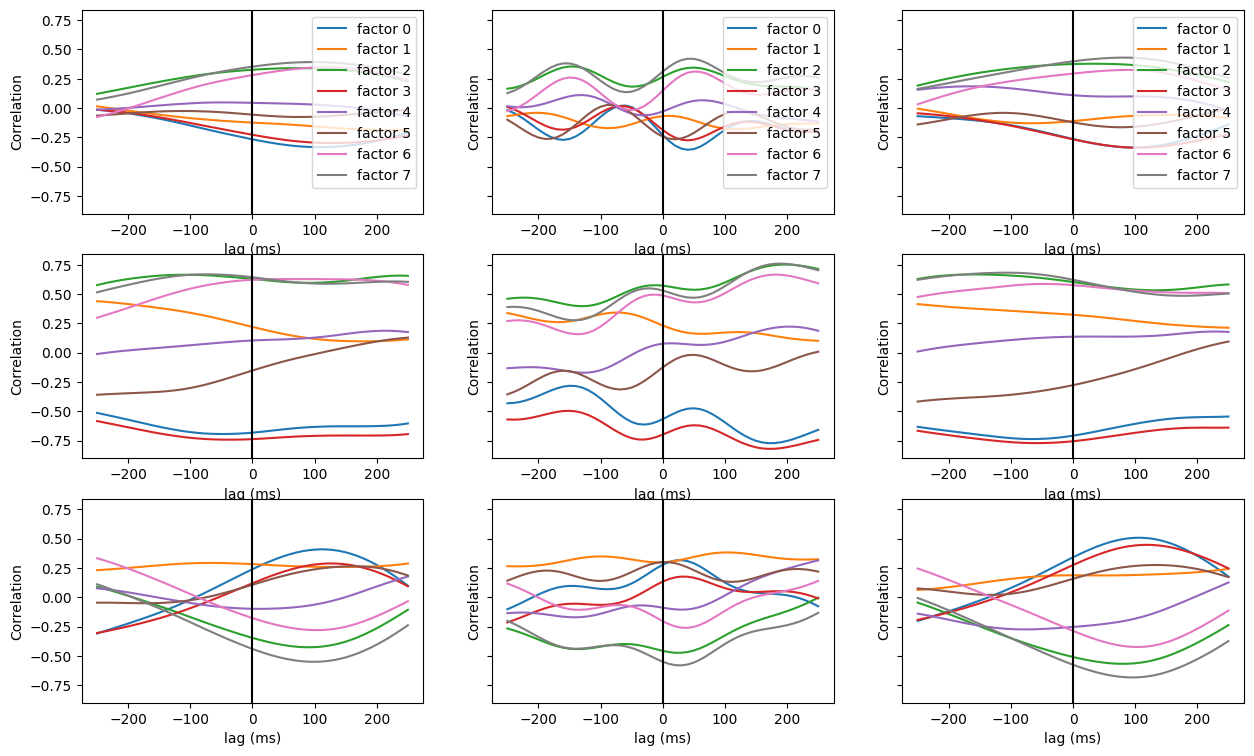

In [136]:
# calculate cross-correlation between each factor and radial velocity
def lagged_corrs(x, y, max_lag = 25, n_folds=N_FOLDS):
    
    lags = np.arange(-max_lag,max_lag+1)
    corrs = []
    for lag in lags:
        if lag==max_lag:
            x_lagged = x[:,max_lag+lag:]
        else:
            x_lagged = x[:,max_lag+lag:-max_lag+lag]
        corr = np.corrcoef(x_lagged.flatten(), y[:,max_lag:-max_lag].flatten())[0,1]
        corrs.append(corr)
    return -lags*10, np.array(corrs)

fig, axes = plt.subplots(3,3,figsize=(15,9),sharey=True)
for epoch in range(3):
        
        for f in range(fac_dim):
            lagcorrs = lagged_corrs(concat_factors[1][concat_epochs==epoch][:,25:,f], 
                                radial_vel[:,25:][concat_epochs==epoch])
            axes[0][epoch].plot(*lagcorrs, c = f'C{f}', label = f'factor {f}')

            lagcorrs = lagged_corrs(concat_factors[1][concat_epochs==epoch][:,25:,f], 
                                concat_true_behavior[:,25:,0][concat_epochs==epoch])
            axes[1][epoch].plot(*lagcorrs, c = f'C{f}')

            lagcorrs = lagged_corrs(concat_factors[1][concat_epochs==epoch][:,25:,f],
                                    concat_true_behavior[:,25:,1][concat_epochs==epoch])
            axes[2][epoch].plot(*lagcorrs, c = f'C{f}')

        axes[0][epoch].legend(loc='upper right')
        for ax in axes:
            ax[epoch].axvline(0,c='k')
            ax[epoch].set_xlabel('lag (ms)')
            ax[epoch].set_ylabel('Correlation')

# Plot firing rate difference with/without controls

In [ ]:
len(both_rates[0])

117

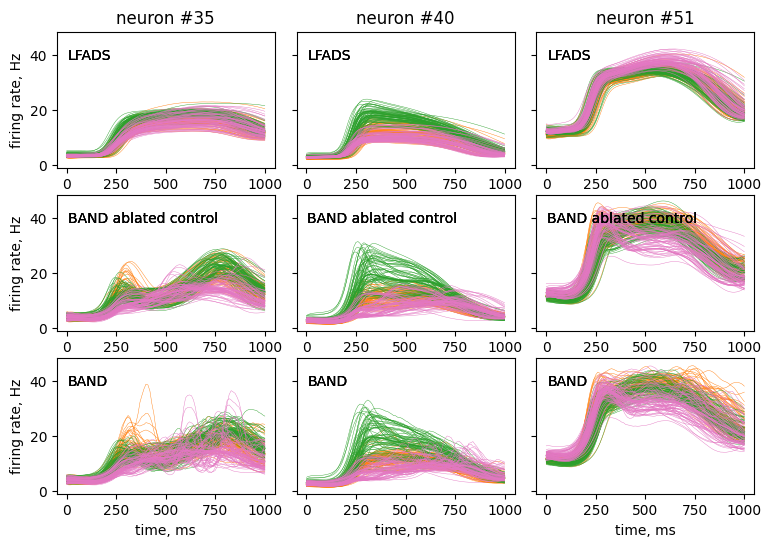

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 6), sharey=True)

for k, (n, sub) in enumerate(zip([35, 40, 51], [[1, 2, 6], [1,2, 6], [1,2, 6]])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_rates[0], concat_noci_rates[-1], concat_rates[-1]],
                                        ['LFADS', 'BAND ablated control', 'BAND'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[i, k].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[i, k].plot(
                    time, frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[0, k].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[i, k].set_ylabel("firing rate, Hz")
                axes[i, k].set_xlabel("time, ms")
                axes[i, k].text(0.05, 0.8, title, transform=axes[i, k].transAxes, ha='left')
                # axes[i, k].set_ylim([0, 65])

# axes[0, 0].set_title("LFADS")
# axes[0, 1].set_title("Ctrl-TNDM")

# plt.legend(loc=(1.5, 0))
plt.subplots_adjust(wspace=0.1)
plt.savefig(f"fig3c.svg")

In [ ]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

# widget to scroll through trials
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

@widgets.interact
def plot_trial(trial_id=widgets.IntSlider(min=0, max=valid_data.shape[0]-1, step=1, value=0)):

    fig = plt.figure(figsize=(10, 4))

    # blank = fig.add_axes([0,0,1,1], frameon=True)

    axis_IC = fig.add_axes([0.05, 0.6, 0.1, 0.25])

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    # print(train_ic.shape,ic_pca.shape)

    axis_IC.set_title('Initial Conditions')
    axis_IC.scatter(*ic_pca.T,c=cm.rainbow(get_target_ids(true_target_direction)/8),s=2)
    axis_IC.scatter(*ic_pca[trial_id],c='k',
                    s=50,marker='*')
    axis_IC.scatter(*ic_pca[trial_id],c=cm.rainbow(get_target_ids(true_target_direction)/8)[trial_id],
                    s=20,marker='*')
    axis_IC.set_xlabel('PC1')
    axis_IC.set_ylabel('PC2')
    axis_IC.set_xticks([])
    axis_IC.set_yticks([])

    time = np.arange(controls.shape[1])*bin_size_ms
    axis_controls = fig.add_axes([0.05, 0.15, 0.25, 0.25])
    axis_controls.set_title('Controls')
    axis_controls.plot(time,controls[trial_id])
    axis_controls.set_xlabel('Time (ms)')
    axis_controls.set_ylabel('Control input')

    axis_factors = fig.add_axes([0.38, 0.6, 0.25, 0.25])
    axis_factors.set_title('Autonomous Factors')
    axis_factors.plot(time,(noci_factors[trial_id] - noci_factors[trial_id].mean(0))[:])
    axis_factors.set_xlabel('Time (ms)')
    axis_factors.set_ylabel('Factor')

    axis_noci_factors = fig.add_axes([0.38, 0.15, 0.25, 0.25])
    axis_noci_factors.set_title('Controlled Factors')
    axis_noci_factors.plot(time,(factors[trial_id] - factors[trial_id].mean(0))[:])
    axis_noci_factors.set_xlabel('Time (ms)')
    axis_noci_factors.set_ylabel('Factor')

    # draw an arrow from IC to autonomous factors

    axis_noci_behavior = fig.add_axes([0.71, 0.6, 0.25, 0.25])
    axis_behavior = fig.add_axes([0.71, 0.15, 0.25, 0.25])
    axis_noci_behavior.set_title('Behavior prediction from Autonomous')
    axis_behavior.set_title('Behavior prediction from Controlled')
    axis_noci_behavior.set_xlabel('Time (ms)')
    axis_noci_behavior.set_ylabel('Behavior')
    axis_behavior.set_xlabel('Time (ms)')
    axis_behavior.set_ylabel('Behavior')
    for i in [0,1]:
        axis_noci_behavior.plot(noci_behavior[trial_id][:,i],c=f'C{i}')
        axis_noci_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
        axis_behavior.plot(behavior[trial_id][:,i],c=f'C{i}')
        axis_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
    axis_noci_behavior.legend(['Predicted','True'])
    axis_behavior.legend(['Predicted','True'])

interactive(children=(IntSlider(value=0, description='trial_id', max=115), Output()), _dom_classes=('widget-in…

# Make sure that behavior is decodable from neural firing

In [ ]:
from plot_helpers import get_random_trials2plot

def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,10,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    if component == 0:
        r2 = r"$R^2$"
        axes[0].set_title(f'{title}: {r2} = {R2_iso_vel*100:.0f}%',loc='left')

np.random.seed(42)
dir_index = get_target_ids(concat_target_direction)
t2p = get_random_trials2plot(dir_index, concat_epochs.astype('int'), 1)

In [ ]:
t2p

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(0.0, 1.0, 0.0, 1.0)

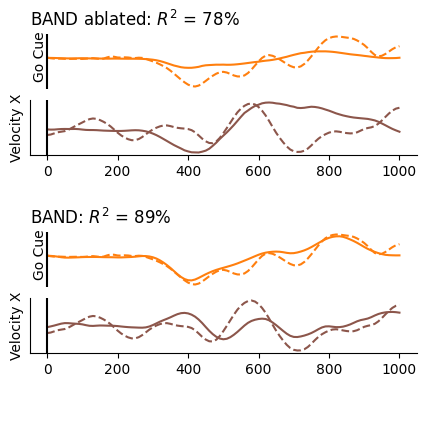

In [ ]:
fig, axes = plt.subplots(6,1,figsize=(5,5))
select = [1,5]
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, axes[:2], 
              'all', 'AD', select = select, component=0,title="BAND ablated")
axes[1].set_xlabel('')
axes[2].axis('off')
plot_beh_pred(concat_true_behavior, concat_behaviors[1],
              dir_index, t2p, axes[3:5], 
              'all', 'AD', select = select, component=0,title="BAND")
axes[4].set_xlabel('')
axes[5].axis('off')

# Make a print-ready figure

### calculate base LL

In [ ]:
from scipy.stats import poisson
valid_mean_count = concat_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(concat_data, valid_mean_count)
n_sp = concat_data.sum()

valid_LL = {'LFADS': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[0]), 
            'BAND': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[1]),
            'LFADS_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[0]), 
            'BAND_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[1])}
valid_co_bps = {key: np.sum(valid_LL[key] - base_LL)/(n_sp * np.log(2)) for key in valid_LL.keys()}
valid_co_bps

{'LFADS': 0.12394825224626142,
 'BAND': 0.14322803625666963,
 'LFADS_noci': 0.12361777114169514,
 'BAND_noci': 0.13065149453464042}

### prepare factor in ordered trials

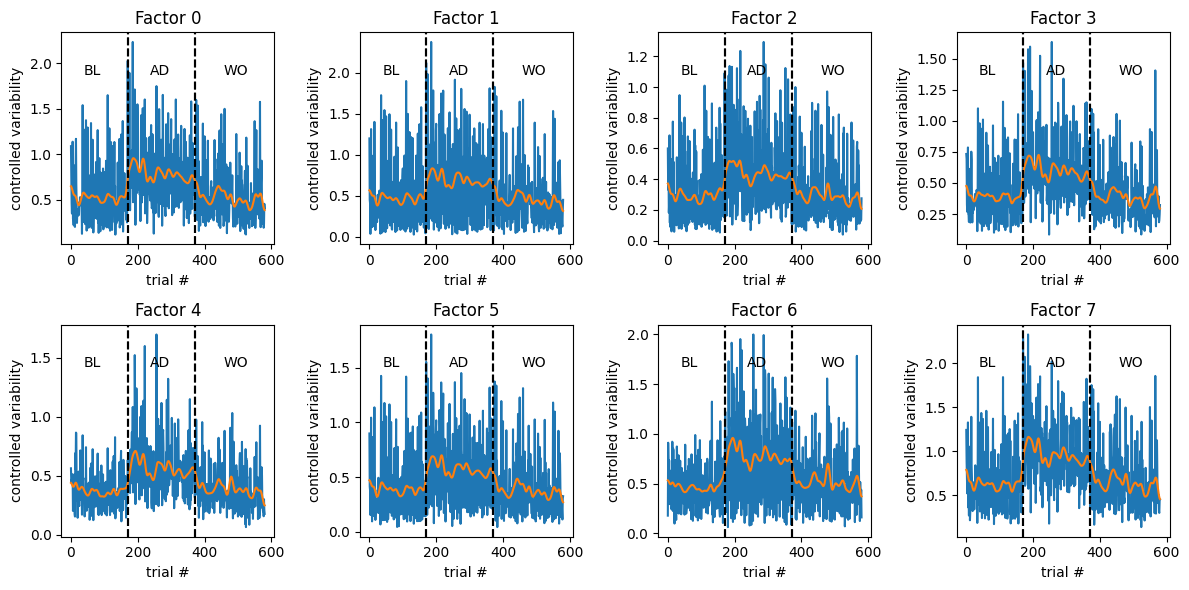

In [ ]:
factors_pull = concat_factors[1]
factors_noci_pull = concat_factors_noci[1]
ids_pull = concat_ids.copy()
epochs_pull = concat_epochs

ids_pull[epochs_pull == 1] = ids_pull[epochs_pull == 1] + 500
ids_pull[epochs_pull == 2] = ids_pull[epochs_pull == 2] + 1000

assert np.all(np.diff(ids_pull) > 0), 'IDs are not sorted'

fig, axes = plt.subplots(2,factors.shape[-1]//2, figsize=(12, 6))
for factor_id, ax in enumerate(axes.flatten()):
    fd = (factors_pull[:,:,factor_id]-factors_noci_pull[:,:,factor_id])
    ax.plot(fd.std(1), label='BAND')
    # gaussian filter
    from scipy.ndimage import gaussian_filter1d
    ax.plot(gaussian_filter1d(fd.std(1), 5))
    ax.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
    ax.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')
    n_BL = np.sum(epochs_pull==0)
    n_AD = np.sum(epochs_pull==1)
    n_WO = np.sum(epochs_pull==2)
    n = n_BL + n_AD + n_WO
    ax.axvline(n_BL, color='k', linestyle='--')
    ax.axvline(n_BL+n_AD, color='k', linestyle='--')
    ax.text(0.5 * n_BL / n, 0.8, 'BL', transform=ax.transAxes, ha='center')
    ax.text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=ax.transAxes, ha='center')
    ax.text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=ax.transAxes, ha='center')
    ax.set_title(f'Factor {factor_id}')
    ax.set_ylabel('controlled variability')
    ax.set_xlabel('trial #')

plt.tight_layout()

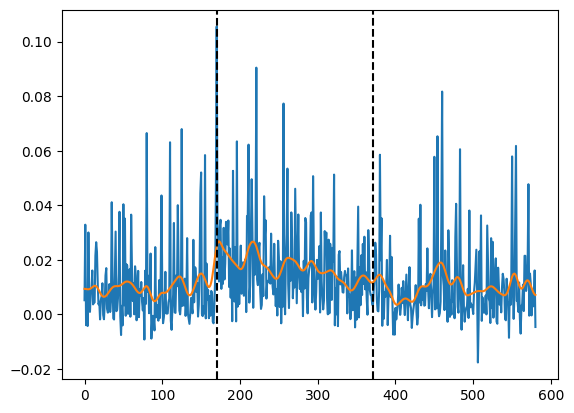

In [ ]:
n_sp = concat_data.sum(1).sum(1)
data_pull = concat_data
base_LL_pull = poisson.logpmf(data_pull, data_pull.mean(0).mean(0))
cobps_pull = (poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[1]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2)) 
cobps_noci_pull = (poisson.logpmf(concat_data,(bin_size_ms / 1000) * concat_noci_rates[1]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2))
plt.plot(cobps_pull- cobps_noci_pull)
# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')

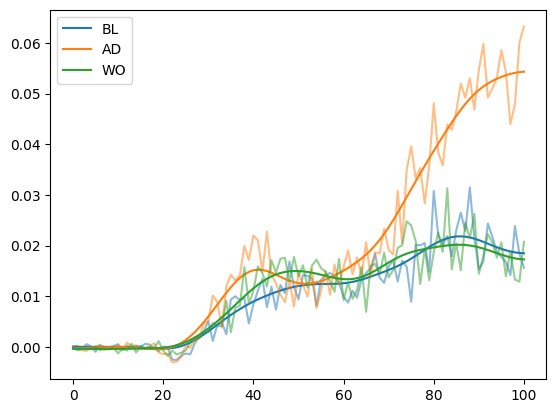

In [ ]:
both_rates_pull = concat_rates[1]
both_noci_rates_pull = concat_noci_rates[1]

for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = data_pull[epochs_pull==e].sum(0).sum(-1)
    cobps = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_noci_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    plt.plot(cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    plt.plot(gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
plt.legend()


### then plot the figure

In [ ]:
from goodman_panels import panels, panel_specs, label_panel, label_panels

In [ ]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
    # aspect = bbox.width / bbox.height
    # print(aspect)

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

/tmp/ipykernel_181137/3912093386.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['C0'].set_xticklabels(axes['C0'].get_xticklabels(), rotation=90)


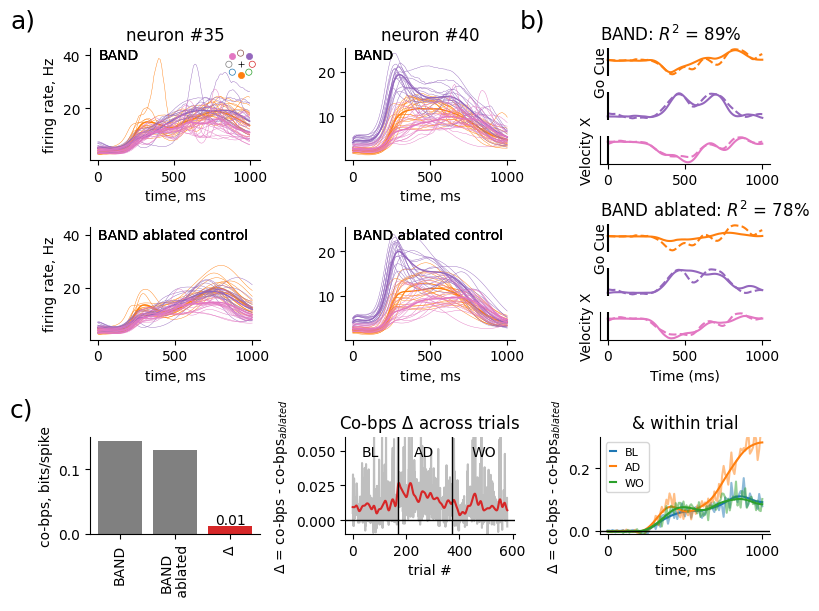

In [ ]:
layout = '''
AAB
AAB
CCC
'''
fig = plt.figure(figsize=(8, 6))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.1, 'right': .95, 'bottom': 0.12, 'top': 0.93, 'hspace': 1., 'wspace': .5})
axes = {}
# for letter in 'C':
#     axes[letter] = ax = fig.add_subplot(specs[letter])
#     label_panel(ax, letter)
gs.set_width_ratios([1,1,1])
gs.set_height_ratios([1,1,1])

# subgs = specs['A'].subgridspec(1, 4, wspace=0.3)
# for i in range(4):
#     axes[f"A{i}"] = ax = fig.add_subplot(subgs[i])
# label_panel(axes['A0'], 'A')

subgs = specs['A'].subgridspec(2, 2, wspace=0.5)
for j in range(2):
    for i in range(2):
        if j == 0:
            axes[f"A{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
        else:
            axes[f'A{j}{i}'] = ax = fig.add_subplot(subgs[j,i], sharey=axes[f'A0{i}'])
label_panel(axes['A00'], 'a', postfix=')')

subgs = specs['B'].subgridspec(2*3+1, 1, wspace=0.1)
for j in range(2*3+1):
    axes[f"B{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['B0'], 'b', postfix=')')

subgs = specs['C'].subgridspec(1, 3, wspace=0.5)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    axes[f"C{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['C0'], 'c', postfix=')')


select = [1,4,6] # directions to plot
for k, (n, sub) in enumerate(zip([35, 40], [select,select,select])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_rates[1], concat_noci_rates[1]],
                                        ['BAND', 'BAND ablated control'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[f'A{i}{k}'].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[f'A{i}{k}'].plot(
                    time, frs[mask][::4,..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[f'A0{k}'].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[f'A{i}{k}'].set_ylabel("firing rate, Hz")
                axes[f'A{i}{k}'].set_xlabel("time, ms")
                axes[f'A{i}{k}'].text(0.05, 0.9, title, transform=axes[f'A{i}{k}'].transAxes, ha='left')
one_hot_select = [1 if s in select else 0 for s in range(8)]                
make_task_schematics(axes['A00'], 0.9,0.9,0.07,aspect=1.5,shown=one_hot_select)

# panel C
plot_beh_pred(concat_true_behavior, concat_behaviors[1], 
              dir_index, t2p, [axes[f'B{i}'] for i in range(3)], 
              'all', 'AD', select = select, component=0,title="BAND")
axes['B2'].set_xlabel('')
axes['B3'].axis('off')
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, [axes[f'B{i}'] for i in range(4,7)], 
              'all', 'AD', select = select, component=0,title="BAND ablated")

for k in axes.keys():
    axes[k].spines['right'].set_visible(False)
    axes[k].spines['top'].set_visible(False)

# Panel A: plot oscillating factor variability
axes['C0'].bar(['BAND', 'BAND\n ablated', r'$\Delta$'], 
               [valid_co_bps['BAND'], valid_co_bps['BAND_noci'], 
                valid_co_bps['BAND'] - valid_co_bps['BAND_noci']],
               color=['grey','grey','C3'])
axes['C0'].set_xticklabels(axes['C0'].get_xticklabels(), rotation=90)
axes['C0'].set_ylabel('co-bps, bits/spike')
axes['C0'].text(2, (valid_co_bps['BAND'] - valid_co_bps['BAND_noci'])*1.2,
                f"{valid_co_bps['BAND'] - valid_co_bps['BAND_noci']:.2f}", ha='center')

axes['C1'].plot(cobps_pull- cobps_noci_pull,alpha=0.5,c='grey')
axes['C1'].plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, 5),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['C1'].axvline(n_BL, color='k', linewidth=1)
axes['C1'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['C1'].axhline(0, color='k', linewidth=1)
axes['C1'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['C1'].transAxes, ha='center')
axes['C1'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['C1'].transAxes, ha='center')
axes['C1'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['C1'].transAxes, ha='center')
axes['C1'].set_xlabel('trial #')
axes['C1'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
axes['C1'].set_title(r'Co-bps $\Delta$ across trials')
# axes['C1'].set_yticks([0,0.05])
axes['C1'].set_ylim([-0.01,0.06])

axes['C2'].set_title('& within trial')
time = np.arange(concat_data.shape[1])*bin_size_ms
for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = valid_data[valid_epoch==e].sum(0).sum(-1)
    cobps = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_noci_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    axes['C2'].plot(time, cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    axes['C2'].plot(time, gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
axes['C2'].legend(loc='upper left',handlelength=.5,fontsize=8)
axes['C2'].set_xlabel('time, ms')
axes['C2'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
# axes['C2'].set_yticks([0,0.05])
axes['C2'].axhline(0, color='k', linewidth=1)
axes['C2'].set_ylim([-0.01,0.3])


plt.subplots_adjust(hspace=0.6)
# plt.tight_layout()
plt.savefig(f"figs/fig6_{dataset_name}_{model_name}.pdf")
plt.savefig(f"figs/fig6_{dataset_name}_{model_name}.png")

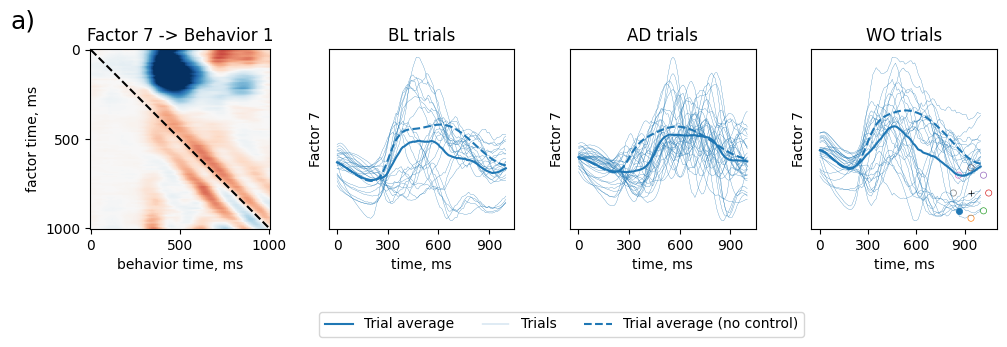

In [ ]:
layout = '''
AAA
CCB
CCB
'''
fig = plt.figure(figsize=(10, 10))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.08, 'right': .99, 'bottom': 0.05, 'top': 0.95, 'hspace': 1, 'wspace': .3})
axes = {}
# for letter in 'C':
#     axes[letter] = ax = fig.add_subplot(specs[letter])
#     label_panel(ax, letter)
gs.set_width_ratios([1,1,1])
gs.set_height_ratios([1,1,1])

subgs = specs['A'].subgridspec(1, 4, wspace=0.3)
for i in range(4):
    axes[f"A{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['A0'], 'a', postfix=')')

# select what to plot
factor_id = 7
beh_id = 1
factors = concat_factors[1] # BAND
time = np.arange(factors.shape[1]) * 10

# Panel A: plot oscillation weights & factors
r = np.std(beh_W)*4
axes['A0'].imshow(beh_W[:,factor_id,:,beh_id], cmap='RdBu', vmin=-r, vmax=r)
axes['A0'].set_xlabel('behavior time, ms')
axes['A0'].set_ylabel('factor time, ms')
axes['A0'].plot([0,seq_len-1], [0, seq_len-1], 'k--')
axes['A0'].set_title(f'Factor {factor_id} -> Behavior {beh_id}')
axes['A0'].set_xticks([0,50,100])
axes['A0'].set_xticklabels([0,500,1000])
axes['A0'].set_yticks([0,50,100])
axes['A0'].set_yticklabels([0,500,1000])

unique_dirs = np.unique(true_target_direction)

for e, e_title in enumerate(["BL", "AD", "WO"]):
    for k, d in enumerate(unique_dirs):
        if d in unique_dirs[[0]]:
            mask = (concat_target_direction == d) & (concat_epochs == e)
            label = 'Trial average' if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, factors[..., factor_id][mask].mean(0), linewidth=1.5, c=f"C{k}", label=label
            )
            label = ['Trials'] + [None for _ in range(np.sum(mask)-1)] if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, factors[..., factor_id][mask].T, linewidth=0.2, c=f"C{k}", alpha=1, label=label
            )
            label = 'Trial average (no control)' if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, concat_factors_noci[1][..., factor_id][mask].mean(0), linewidth=1.5, linestyle='--', c=f"C{k}", alpha=1, label=label
            )
            axes[f'A{e+1}'].set_yticks([])
            axes[f'A{e+1}'].set_xlabel("time, ms")
            axes[f'A{e+1}'].set_ylabel(f"Factor {factor_id}")
            axes[f'A{e+1}'].set_title(f"{e_title} trials")
            axes[f'A{e+1}'].set_xticks([0, 300, 600, 900])
            if e == 0:
                axes[f'A{e+1}'].legend(loc=[-.05,-.6], ncol = 3 )

make_task_schematics(axes[f'A3'], 0.9, .2, 0.1,aspect=1.4,shown=[1,0,0,0,0,0,0,0])


In [ ]:
true_b

NameError: name 'true_b' is not defined